In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import math
from torch.utils.data import Dataset, DataLoader, random_split
import random
from tqdm import tqdm
from pathlib import Path

In [17]:
# If prenlp is not installed, let's try to install it
try:
    import prenlp
except ImportError:
    print("Installing prenlp package...")
    !pip install prenlp
    import prenlp

# If sentencepiece is not installed, let's try to install it
try:
    import sentencepiece as spm
except ImportError:
    print("Installing sentencepiece package...")
    !pip install sentencepiece
    import sentencepiece as spm

In [18]:
#######################################
#1) SentencePiece Training / Wrapper
#######################################
def train_tokenizer(train_dataset, model_prefix="spm_imdb", vocab_size=8000):
    """
    Train a SentencePiece model on the entire IMDb training text if not already present.
    """
    model_file = f"{model_prefix}.model"
    if os.path.exists(model_file):
        print(f"Tokenizer model '{model_file}' exists; skipping training.")
        return model_file

    print(f"Training SentencePiece tokenizer (vocab_size={vocab_size}) ...")

    # Write the training texts to a file
    with open("imdb_train_texts.txt", "w", encoding="utf-8") as f:
        for text, _ in train_dataset:
            f.write(text + "\n")

    # Train the SentencePiece model
    spm.SentencePieceTrainer.Train(
        input="imdb_train_texts.txt",
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        character_coverage=1.0,  # cover full character set
        model_type='bpe'         # can be 'bpe' or 'unigram', etc.
    )

    print(f"Tokenizer model saved: {model_file}")
    return model_file

class SPTokenizer:
    """
    Simple wrapper around the SentencePiece processor:
    - loads the model
    - provides encode() to get subword IDs
    - tracks vocab_size (we add +1 for a custom <pad> token)
    - pads token sequences to max_len
    """
    def __init__(self, model_path, max_len=200):
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(model_path)

        self.max_len = max_len

        # SentencePiece vocab size (includes <unk>, <s>, </s>).
        # By default, it does NOT have a <pad> token,
        # so let's designate the next ID as <pad>.
        self.vocab_size = self.sp.GetPieceSize()
        self.pad_id = self.vocab_size
        self.vocab_size += 1  # account for newly added pad token

    def encode(self, text):
        # Convert text to subword IDs
        token_ids = self.sp.EncodeAsIds(text)
        # Truncate if needed
        token_ids = token_ids[:self.max_len]
        return token_ids

    def pad_batch(self, batch_ids):
        """
        Given a list of lists of token IDs, pad all to self.max_len with pad_id.
        """
        padded = []
        for tok_ids in batch_ids:
            needed = self.max_len - len(tok_ids)
            if needed > 0:
                tok_ids = tok_ids + [self.pad_id]*needed
            padded.append(tok_ids)
        return torch.tensor(padded, dtype=torch.long)

########################################
# 2) IMDb Dataset
########################################
class IMDBDataset(Dataset):
    """
    Uses prenlp.data.IMDb, which returns:
    imdb_full = [ train_data, test_data ]
    train_data = [ (text, 'pos'/'neg'), ... ]
    We'll store it directly, then rely on a collate_fn for numeric encoding.
    """
    def __init__(self, split="train"):
        super().__init__()
        imdb_full = prenlp.data.IMDB(root='.data')
        if split == "train":
            self.samples = imdb_full[0]  # 25k (text, label) pairs
        else:
            self.samples = imdb_full[1]  # 25k (text, label) pairs

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]  # (text, 'pos'/'neg')

def collate_fn_subword(batch, tokenizer, use_mask=False):
    """
    Convert text -> subword IDs, pad to max_len, and convert pos/neg -> 1/0.
    If use_mask=True, also returns an attention mask.
    """
    texts, labels_str = zip(*batch)

    # Convert labels
    labels = [0 if lbl == 'neg' else 1 for lbl in labels_str]

    # Encode with tokenizer
    batch_ids = [tokenizer.encode(txt) for txt in texts]

    # Pad
    padded_ids = tokenizer.pad_batch(batch_ids)

    if use_mask:
        # Create attention mask (1 for tokens, 0 for padding)
        attention_mask = (padded_ids != tokenizer.pad_id).long()
        return padded_ids, attention_mask, torch.tensor(labels, dtype=torch.long)
    else:
        return padded_ids, torch.tensor(labels, dtype=torch.long)

########################################
# 3) Our simplified transformer architecture with optional attention mask
########################################
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        # Projection matrices
        self.W_Q = nn.Parameter(torch.randn(d_model, d_model))
        self.W_K = nn.Parameter(torch.randn(d_model, d_model))
        self.W_V = nn.Parameter(torch.randn(d_model, d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_model))

    def forward(self, X, mask=None):
        # X: [batch_size, seq_len, d_model]
        # mask: [batch_size, seq_len]
        B, N, _ = X.shape

        # Projections
        Q = (X @ self.W_Q).view(B, N, self.n_heads, self.head_dim).transpose(1, 2)
        K = (X @ self.W_K).view(B, N, self.n_heads, self.head_dim).transpose(1, 2)
        V = (X @ self.W_V).view(B, N, self.n_heads, self.head_dim).transpose(1, 2)

        # Attention
        scores = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # [B, n_heads, N, N]

        # Apply attention mask if provided
        if mask is not None:
            # Convert 1D mask [B, N] to 2D mask [B, 1, 1, N]
            # then broadcast to match scores shape [B, n_heads, N, N]
            mask = mask.unsqueeze(1).unsqueeze(2)

            # Apply mask (set -inf where mask == 0)
            scores = scores.masked_fill(mask == 0, -1e9)

        A = F.softmax(scores, dim=-1)

        # Output
        out = (A @ V).transpose(1, 2).reshape(B, N, self.d_model)
        return out @ self.W_O

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Attention with skip connection and mask
        x = self.norm1(x + self.attention(x, mask))

        # Feed-forward with skip connection
        x = self.norm2(x + self.ff(x))

        return x

class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, max_len=5000):
        super().__init__()

        # Token embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        # Transformer layers
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_ff)
            for _ in range(n_layers)
        ])

        # Classification layer
        self.classifier = nn.Linear(d_model, 2)  # 2 classes: positive/negative

    def forward(self, x, mask=None):
        bsz, seq_len = x.size()

        # Position IDs
        pos_ids = torch.arange(0, seq_len, device=x.device).unsqueeze(0)

        # Embedding and positional encoding
        x = self.token_embedding(x)  # [B, N, D]
        x = x + self.pos_embedding(pos_ids)

        # Transformer layers with mask
        for layer in self.layers:
            x = layer(x, mask)

        # Pooling (average over sequence, taking mask into account)
        if mask is not None:
            # Calculate average only over non-masked tokens
            x = (x * mask.unsqueeze(-1)).sum(dim=1) / mask.sum(dim=1, keepdim=True)
        else:
            # If no mask, average over the entire sequence
            x = x.mean(dim=1)

        # Classification
        return self.classifier(x)

########################################
# 4) Tests for conservation laws
########################################
def get_attention_block_weights(model, layer_idx=0):
    """
    Extracts the W_Q and W_K matrices from a transformer layer.
    Equivalent to the get_residual_block_weights function for ResNet.
    """
    W_Q = model.layers[layer_idx].attention.W_Q
    W_K = model.layers[layer_idx].attention.W_K
    return [(f"layer_{layer_idx}_W_Q", W_Q), (f"layer_{layer_idx}_W_K", W_K)]

def compute_conservation_values(block_weights, head_idx=0):
    """
    Calculates the difference between the squared Frobenius norms of W_Q and W_K matrices
    for a specific attention head.
    Equivalent to compute_block_differences for ResNet.
    """
    # Extract weights
    W_Q = block_weights[0][1]  # Q weights
    W_K = block_weights[1][1]  # K weights

    # Get dimensions
    d_model = W_Q.size(0)
    n_heads = 8  # Number of heads in our model (fixed parameter)
    head_dim = d_model // n_heads

    # Reshape to extract a specific head
    Ws_Q = (W_Q).view(d_model, n_heads, head_dim).transpose(0, 1)
    Ws_K = (W_K).view(d_model, n_heads, head_dim).transpose(0, 1)
    W_Q_h = Ws_Q[head_idx]
    W_K_h = Ws_K[head_idx]

    # Calculate the conservation law H = W_Q^T W_Q - W_K^T W_K
    H = W_Q_h.T @ W_Q_h - W_K_h.T @ W_K_h

    # For simplicity, we just return the Frobenius norm of H
    # (a single value like in the ResNet code)
    return [torch.norm(H).item()]

def train_transformer(learning_rate, epochs, max_batches, seed, filename_prefix, use_mask=False):
    """
    Main function to train a transformer and track conserved quantities.
    Modeled after the train_resnet function.
    use_mask parameter to enable or disable the use of attention masks.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set random seeds
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Model parameters
    torch.set_default_dtype(torch.float64)
    B = 32  # batch size
    D = 64  # model dimension
    n_heads = 8  # number of attention heads
    n_layers = 2  # number of transformer layers
    max_len = 200  # max sequence length for SentencePiece
    d_ff = 4 * D  # feed-forward dimension

    # Load data
    print(f"Loading IMDb dataset for lr={learning_rate}, seed={seed}, use_mask={use_mask}...")
    train_data = IMDBDataset(split="train")
    test_data = IMDBDataset(split="test")

    # Configure tokenizer
    spm_model_path = train_tokenizer(train_data, model_prefix="spm_imdb", vocab_size=5000)
    tokenizer = SPTokenizer(spm_model_path, max_len=max_len)
    vocab_size = tokenizer.vocab_size

    # Define collate function
    def collate_wrapper(batch):
        return collate_fn_subword(batch, tokenizer, use_mask=use_mask)

    # Configure dataloaders
    train_loader = DataLoader(
        train_data, batch_size=B, shuffle=True, collate_fn=collate_wrapper
    )
    test_loader = DataLoader(
        test_data, batch_size=B, shuffle=False, collate_fn=collate_wrapper
    )

    # Initialize model with a specific seed for weight initialization
    seed_weight_init = 41
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_weight_init)
    torch.manual_seed(seed_weight_init)
    np.random.seed(seed_weight_init)
    model = SentimentTransformer(vocab_size, D, n_heads, n_layers, d_ff, max_len=max_len).to(device)

    # Return to the run seed
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Loss and optimizer (without momentum or weight_decay)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.0, weight_decay=0.0)

    # Variables to track history
    differences_history = []
    loss_history = []
    batch_count = 0

    # Get a fixed test batch for consistent evaluation
    data_iter = iter(test_loader)
    eval_data = next(data_iter)

    if use_mask:
        eval_inputs, eval_masks, eval_labels = eval_data
        eval_inputs, eval_masks, eval_labels = eval_inputs.to(device), eval_masks.to(device), eval_labels.to(device)
    else:
        eval_inputs, eval_labels = eval_data
        eval_inputs, eval_labels = eval_inputs.to(device), eval_labels.to(device)
        eval_masks = None

    # Calculate and save initial differences
    block_weights = get_attention_block_weights(model)
    conserved_functions = compute_conservation_values(block_weights)
    differences_history.append(conserved_functions)

    # Calculate initial loss before training
    model.eval()
    initial_loss = 0.0
    n_batches_for_loss = 10
    with torch.no_grad():
        batch_count = 0
        for data in tqdm(train_loader, desc="Computing initial loss"):
            if use_mask:
                inputs, masks, labels = data
                inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
                outputs = model(inputs, masks)
            else:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

            loss = criterion(outputs, labels)
            initial_loss += loss.item()
            batch_count += 1
            if batch_count >= n_batches_for_loss:
                break
    initial_loss /= n_batches_for_loss
    loss_history.append(initial_loss)
    print(f'Initial loss before training: {initial_loss:.3f}')
    model.train()

    # Training loop
    batch_count = 0
    for epoch in range(epochs):
        model.train()

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}, LR={learning_rate}, Seed={seed}, Mask={use_mask}"):
            if use_mask:
                inputs, masks, labels = data
                inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs, masks)
            else:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_count += 1

            # Record metrics for each batch
            if batch_count % 1 == 0:
                # Calculate differences for attention blocks
                block_weights = get_attention_block_weights(model)
                conserved_functions = compute_conservation_values(block_weights)
                differences_history.append(conserved_functions)
                loss_history.append(loss.item())

            if batch_count >= max_batches:
                break

        print(f'Epoch {epoch + 1} completed')

    # Save results
    results = {
        'learning_rate': learning_rate,
        'seed': seed,
        'use_mask': use_mask,
        'differences_history': differences_history,
        'loss_history': loss_history,
    }

    save_dir = Path('results')
    save_dir.mkdir(exist_ok=True)
    mask_str = "with_mask" if use_mask else "no_mask"
    torch.save(results, save_dir / f'{filename_prefix}_transformer_results_lr_{learning_rate}_seed_{seed}_{mask_str}.pt')

    return results


# Run training for different learning rates and seeds
if __name__ == "__main__":
    # Define learning rates and seeds to test
    learning_rates = [1e-3, 3e-3, 5e-3]
    seeds = [2, 3, 4, 5, 6, 7, 8, 9]
    # Run tests for each seed/lr combination
    for seed in seeds:
        for lr in learning_rates:
            epoch = 1
            max_batches = 50
            train_transformer(lr, epoch, max_batches, seed, filename_prefix="4", use_mask = True)
            train_transformer(lr, epoch, max_batches, seed, filename_prefix="4", use_mask = False)

Loading IMDb dataset for lr=0.001, seed=2, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:14<20:04,  1.56s/it]


Initial loss before training: 0.690


Epoch 1/1, LR=0.001, Seed=2, Mask=True:   6%|▋         | 49/782 [01:43<25:46,  2.11s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=2, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:07<10:26,  1.23it/s]


Initial loss before training: 0.695


Epoch 1/1, LR=0.001, Seed=2, Mask=False:   6%|▋         | 49/782 [01:27<21:41,  1.78s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=2, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:40,  1.14s/it]


Initial loss before training: 0.690


Epoch 1/1, LR=0.003, Seed=2, Mask=True:   6%|▋         | 49/782 [01:45<26:11,  2.14s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=2, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:16,  1.05it/s]


Initial loss before training: 0.695


Epoch 1/1, LR=0.003, Seed=2, Mask=False:   6%|▋         | 49/782 [01:25<21:14,  1.74s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=2, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:47,  1.15s/it]


Initial loss before training: 0.690


Epoch 1/1, LR=0.005, Seed=2, Mask=True:   6%|▋         | 49/782 [01:43<25:47,  2.11s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=2, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:22,  1.04it/s]


Initial loss before training: 0.695


Epoch 1/1, LR=0.005, Seed=2, Mask=False:   6%|▋         | 49/782 [01:27<21:53,  1.79s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=3, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:34,  1.13s/it]


Initial loss before training: 0.695


Epoch 1/1, LR=0.001, Seed=3, Mask=True:   6%|▋         | 49/782 [01:44<26:10,  2.14s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=3, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:11,  1.06it/s]


Initial loss before training: 0.699


Epoch 1/1, LR=0.001, Seed=3, Mask=False:   6%|▋         | 49/782 [01:28<22:00,  1.80s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=3, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:37,  1.13s/it]


Initial loss before training: 0.695


Epoch 1/1, LR=0.003, Seed=3, Mask=True:   6%|▋         | 49/782 [01:45<26:19,  2.16s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=3, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:08,  1.06it/s]


Initial loss before training: 0.699


Epoch 1/1, LR=0.003, Seed=3, Mask=False:   6%|▋         | 49/782 [01:28<22:06,  1.81s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=3, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<15:09,  1.18s/it]


Initial loss before training: 0.695


Epoch 1/1, LR=0.005, Seed=3, Mask=True:   6%|▋         | 49/782 [01:47<26:41,  2.18s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=3, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:50,  1.00it/s]


Initial loss before training: 0.699


Epoch 1/1, LR=0.005, Seed=3, Mask=False:   6%|▋         | 49/782 [01:28<22:07,  1.81s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=4, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:32,  1.13s/it]


Initial loss before training: 0.698


Epoch 1/1, LR=0.001, Seed=4, Mask=True:   6%|▋         | 49/782 [01:45<26:17,  2.15s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=4, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:05,  1.07it/s]


Initial loss before training: 0.701


Epoch 1/1, LR=0.001, Seed=4, Mask=False:   6%|▋         | 49/782 [01:26<21:32,  1.76s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=4, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:09<14:08,  1.10s/it]


Initial loss before training: 0.698


Epoch 1/1, LR=0.003, Seed=4, Mask=True:   6%|▋         | 49/782 [01:43<25:53,  2.12s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=4, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:26,  1.04it/s]


Initial loss before training: 0.701


Epoch 1/1, LR=0.003, Seed=4, Mask=False:   6%|▋         | 49/782 [01:27<21:53,  1.79s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=4, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:47,  1.15s/it]


Initial loss before training: 0.698


Epoch 1/1, LR=0.005, Seed=4, Mask=True:   6%|▋         | 49/782 [01:44<26:09,  2.14s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=4, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:10,  1.06it/s]


Initial loss before training: 0.701


Epoch 1/1, LR=0.005, Seed=4, Mask=False:   6%|▋         | 49/782 [01:27<21:54,  1.79s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=5, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<15:11,  1.18s/it]


Initial loss before training: 0.703


Epoch 1/1, LR=0.001, Seed=5, Mask=True:   6%|▋         | 49/782 [01:43<25:52,  2.12s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=5, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:30,  1.03it/s]


Initial loss before training: 0.711


Epoch 1/1, LR=0.001, Seed=5, Mask=False:   6%|▋         | 49/782 [01:28<22:06,  1.81s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=5, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:09<13:33,  1.05s/it]


Initial loss before training: 0.703


Epoch 1/1, LR=0.003, Seed=5, Mask=True:   6%|▋         | 49/782 [01:44<26:05,  2.14s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=5, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:39,  1.02it/s]


Initial loss before training: 0.711


Epoch 1/1, LR=0.003, Seed=5, Mask=False:   6%|▋         | 49/782 [01:28<21:58,  1.80s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=5, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:24,  1.12s/it]


Initial loss before training: 0.703


Epoch 1/1, LR=0.005, Seed=5, Mask=True:   6%|▋         | 49/782 [01:45<26:19,  2.15s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=5, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:51,  1.00it/s]


Initial loss before training: 0.711


Epoch 1/1, LR=0.005, Seed=5, Mask=False:   6%|▋         | 49/782 [01:26<21:28,  1.76s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=6, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:09<13:13,  1.03s/it]


Initial loss before training: 0.705


Epoch 1/1, LR=0.001, Seed=6, Mask=True:   6%|▋         | 49/782 [01:45<26:16,  2.15s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=6, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<11:42,  1.10it/s]


Initial loss before training: 0.704


Epoch 1/1, LR=0.001, Seed=6, Mask=False:   6%|▋         | 49/782 [01:26<21:29,  1.76s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=6, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:45,  1.15s/it]


Initial loss before training: 0.705


Epoch 1/1, LR=0.003, Seed=6, Mask=True:   6%|▋         | 49/782 [01:43<25:49,  2.11s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=6, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<11:29,  1.12it/s]


Initial loss before training: 0.704


Epoch 1/1, LR=0.003, Seed=6, Mask=False:   6%|▋         | 49/782 [01:27<21:48,  1.78s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=6, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:31,  1.13s/it]


Initial loss before training: 0.705


Epoch 1/1, LR=0.005, Seed=6, Mask=True:   6%|▋         | 49/782 [01:46<26:30,  2.17s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=6, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:07<10:58,  1.17it/s]


Initial loss before training: 0.704


Epoch 1/1, LR=0.005, Seed=6, Mask=False:   6%|▋         | 49/782 [01:26<21:31,  1.76s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=7, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:44,  1.14s/it]


Initial loss before training: 0.690


Epoch 1/1, LR=0.001, Seed=7, Mask=True:   6%|▋         | 49/782 [01:42<25:32,  2.09s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=7, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<12:19,  1.05it/s]


Initial loss before training: 0.698


Epoch 1/1, LR=0.001, Seed=7, Mask=False:   6%|▋         | 49/782 [01:26<21:31,  1.76s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=7, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:53,  1.16s/it]


Initial loss before training: 0.690


Epoch 1/1, LR=0.003, Seed=7, Mask=True:   6%|▋         | 49/782 [01:41<25:17,  2.07s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=7, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:07<10:40,  1.21it/s]


Initial loss before training: 0.698


Epoch 1/1, LR=0.003, Seed=7, Mask=False:   6%|▋         | 49/782 [01:27<21:47,  1.78s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=7, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:27,  1.12s/it]


Initial loss before training: 0.690


Epoch 1/1, LR=0.005, Seed=7, Mask=True:   6%|▋         | 49/782 [01:45<26:25,  2.16s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=7, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<11:33,  1.11it/s]


Initial loss before training: 0.698


Epoch 1/1, LR=0.005, Seed=7, Mask=False:   6%|▋         | 49/782 [01:26<21:33,  1.76s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=8, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<14:35,  1.13s/it]


Initial loss before training: 0.692


Epoch 1/1, LR=0.001, Seed=8, Mask=True:   6%|▋         | 49/782 [01:45<26:15,  2.15s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=8, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:07<11:24,  1.13it/s]


Initial loss before training: 0.696


Epoch 1/1, LR=0.001, Seed=8, Mask=False:   6%|▋         | 49/782 [01:27<21:45,  1.78s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=8, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:09<13:21,  1.04s/it]


Initial loss before training: 0.692


Epoch 1/1, LR=0.003, Seed=8, Mask=True:   6%|▋         | 49/782 [01:41<25:13,  2.07s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=8, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:08<11:48,  1.09it/s]


Initial loss before training: 0.696


Epoch 1/1, LR=0.003, Seed=8, Mask=False:   6%|▋         | 49/782 [01:24<21:04,  1.73s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=8, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:09<14:04,  1.09s/it]


Initial loss before training: 0.692


Epoch 1/1, LR=0.005, Seed=8, Mask=True:   6%|▋         | 49/782 [01:41<25:17,  2.07s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=8, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:07<10:29,  1.23it/s]


Initial loss before training: 0.696


Epoch 1/1, LR=0.005, Seed=8, Mask=False:   6%|▋         | 49/782 [01:28<21:57,  1.80s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=9, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<15:39,  1.22s/it]


Initial loss before training: 0.696


Epoch 1/1, LR=0.001, Seed=9, Mask=True:   6%|▋         | 49/782 [01:47<26:42,  2.19s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.001, seed=9, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:07<10:47,  1.19it/s]


Initial loss before training: 0.696


Epoch 1/1, LR=0.001, Seed=9, Mask=False:   6%|▋         | 49/782 [01:26<21:41,  1.77s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=9, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<15:20,  1.19s/it]


Initial loss before training: 0.696


Epoch 1/1, LR=0.003, Seed=9, Mask=True:   6%|▋         | 49/782 [01:44<26:07,  2.14s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.003, seed=9, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:07<10:55,  1.18it/s]


Initial loss before training: 0.696


Epoch 1/1, LR=0.003, Seed=9, Mask=False:   6%|▋         | 49/782 [01:28<22:03,  1.81s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=9, use_mask=True...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:10<15:17,  1.19s/it]


Initial loss before training: 0.696


Epoch 1/1, LR=0.005, Seed=9, Mask=True:   6%|▋         | 49/782 [01:44<26:06,  2.14s/it]


Epoch 1 completed
Loading IMDb dataset for lr=0.005, seed=9, use_mask=False...
Tokenizer model 'spm_imdb.model' exists; skipping training.


Computing initial loss:   1%|          | 9/782 [00:07<11:22,  1.13it/s]


Initial loss before training: 0.696


Epoch 1/1, LR=0.005, Seed=9, Mask=False:   6%|▋         | 49/782 [01:26<21:29,  1.76s/it]

Epoch 1 completed


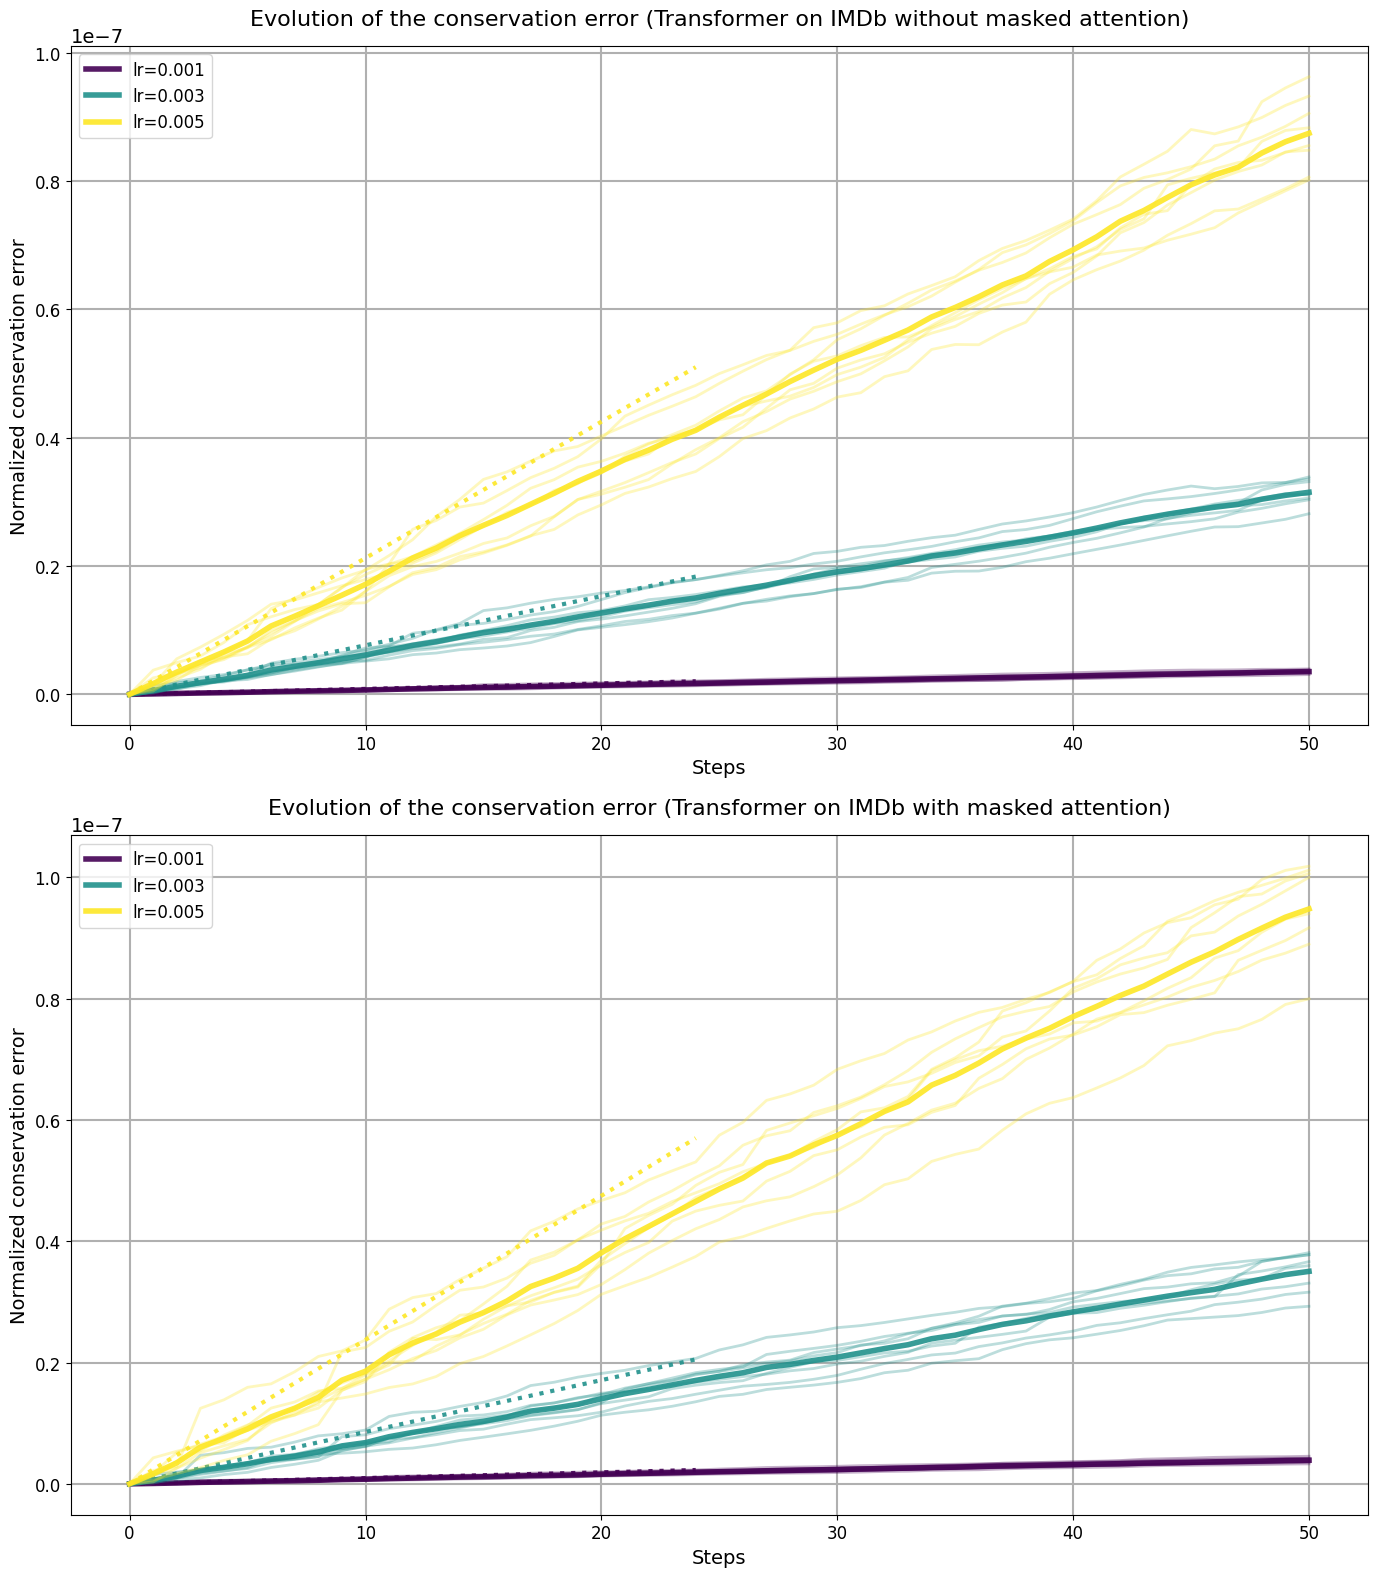

In [30]:
def plot_training_results(filename_prefix):
    """
    Plot training results for masked and unmasked attention in two separate subplots.
    Only shows conservation error (no loss plots).
    Uses different theoretical constants for each plot.
    """
    # Load results for different learning rates
    save_dir = Path('results')

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))
    subplot_axes = [ax1, ax2]

    # Set up mask settings for each subplot
    mask_settings = [False, True]
    subplot_titles = ["without masked attention", "with masked attention"]

    # Different theoretical constants for each case
    theoretical_constants = [0.000085, 0.000095]  # C for no mask, C for with mask

    # Increase font sizes and line widths
    plt.rcParams.update({'font.size': 14})

    # Process both types of results, one per subplot
    for idx, (use_mask, ax, title, C) in enumerate(zip(mask_settings, subplot_axes, subplot_titles, theoretical_constants)):
        mask_str = "with_mask" if use_mask else "no_mask"

        # Group results by learning rate
        lr_results = {}
        for file in save_dir.glob(f'{filename_prefix}_transformer_results_lr_*_{mask_str}.pt'):
            results = torch.load(file)
            lr = results['learning_rate']
            if lr not in lr_results:
                lr_results[lr] = []
            lr_results[lr].append(results)

        if not lr_results:
            ax.text(0.5, 0.5, f"No results found for {mask_str}",
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes, fontsize=14)
            continue

        # Color map for different learning rates
        colors = plt.cm.viridis(np.linspace(0, 1, len(lr_results)))

        for (lr, results_list), color in zip(sorted(lr_results.items()), colors):
            # Calculate mean and standard deviation across seeds
            all_conserved = [r['differences_history'] for r in results_list]

            # Convert to numpy arrays and ensure same length
            min_length = min(len(d) for d in all_conserved)
            all_conserved = [d[:min_length] for d in all_conserved]

            conserved_array = np.array(all_conserved)

            # Calculate steps (x-axis)
            steps = np.arange(min_length)

            # Normalize differences relative to initial value
            diffs = np.abs((conserved_array - conserved_array[:,0][...,np.newaxis,:]) / conserved_array[:,0][...,np.newaxis,:])
            normalized_diffs = np.nanmean(diffs, axis=2)  # Average across features

            # Plot individual curves with transparency
            for i in range(normalized_diffs.shape[0]):
                ax.plot(steps, normalized_diffs[i], '-', color=color, alpha=0.3, linewidth=2)

            # Calculate average across seeds
            normalized_diffs_mean = np.nanmean(normalized_diffs, axis=0)

            # Plot mean line for differences with darker color and thicker line
            ax.plot(steps, normalized_diffs_mean, '-', color=color, alpha=0.9,
                    label=f'lr={lr}', linewidth=4)

            # Plot theoretical curve with subplot-specific constant C
            theoretical = steps * (lr**2) * C
            max_theory_steps = 25

            # Add theory curve with constant displayed in the line label
            ax.plot(steps[:max_theory_steps], theoretical[:max_theory_steps], ':', color=color,
                   alpha=0.9, linewidth=3)

        # Customize subplot
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.legend(fontsize=12)
        ax.grid(True, linewidth=1.5)

        ax.set_xlabel('Steps', fontsize=14)
        ax.set_ylabel('Normalized conservation error', fontsize=14)
        ax.set_title(f'Evolution of the conservation error (Transformer on IMDb {title})',
                    fontsize=16, pad=15)

    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_training_analysis_comparison.png')
    plt.show()

if __name__ == "__main__":
    # Plot masked and unmasked results in separate subplots
    plot_training_results("4")